In [12]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib.  
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [13]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# pydrake imports
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, Parser,
                         PlanarSceneGraphVisualizer, Simulator, VectorSystem,
                         Multiplexer, MatrixGain, LogOutput, ConstantVectorSource, 
                        Saturation, WrapToSystem, LinearQuadraticRegulator, SceneGraph)

# underactuated imports
from underactuated import FindResource, ManipulatorDynamics

## Parse the `.urdf`
The first block of our diagram is the vibrating pendulum.
No need to write its equations of motion by hand: all the parameters of the system are described in its `.urdf` file.
Drake can directly parse this file, and construct a `MultibodyPlant` (i.e. the vibrating-pendulum block in our diagram).
The `.urdf` file contains all the physical data of the system, the visualization parameters (shapes and colors of the bodies), etc.
Its html-like syntax is very easy to understand, give it a try!

Our robot has two bodies:
1. The base. This moves on a 1D rail and oscillates according to the harmonic law $h \sin (\omega t)$.
2. The pendulum. It is connected to the base through a pin. This is the body you will need to control.

**Attention!** Since the robot has two bodies, it also has two configuration variables.
When writing the controller, we will take care of the first (position of the base) and ensure that it oscillates as required.
Then the problem will be reduced to the control of the pendulum only.

<IPython.core.display.Javascript object>


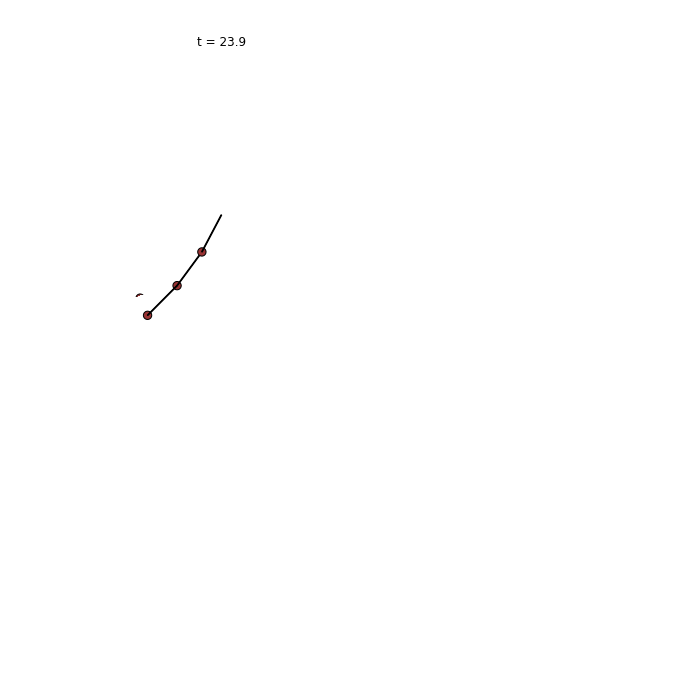

KeyboardInterrupt: 

In [14]:
import os
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

#print(os.getcwd())

# think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram
double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0. # discrete update period , set to zero since system is continuous
)

# parse the urdf and populate the vibrating pendulum
urdf_path = 'three_link.urdf'
Parser(double_pendulum).AddModelFromFile(urdf_path)
double_pendulum.Finalize()

# Set the constant torque (you can change the value here if you like)
torque_system = builder.AddSystem(ConstantVectorSource([[0.], [0.]]))
# print(double_pendulum.get_input_port(0))
#plot_system_graphviz(double_pendulum)
builder.Connect(torque_system.get_output_port(0), double_pendulum.get_input_port(3))
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-4., 4.], ylim=[-4., 4.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
# Simulate
duration = 30.0 if get_ipython() else 0.1 # sets a shorter duration during testing
context.SetTime(0.0)
context.SetContinuousState(np.random.randn(6,1))

AdvanceToAndVisualize(simulator, visualizer, duration)

<IPython.core.display.Javascript object>


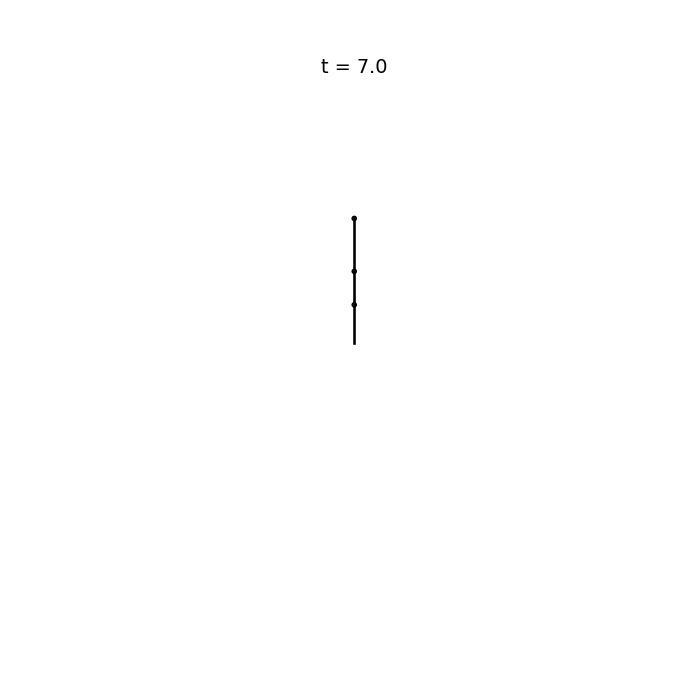

[-0.00607168 -0.01569019 -0.0063666   0.00968613 -0.00182166 -0.01121217]
[-0.00684651  0.00770748  0.01020564 -0.00826348 -0.01655521  0.01099642]
[-0.00378199  0.01349034  0.00544429 -0.0072924   0.00417701  0.01281871]
[ 0.00253651  0.02001437 -0.00819783 -0.00876253  0.00778154  0.00472973]
[-0.00497015  0.02244169 -0.00097783 -0.00161279  0.00842508 -0.00180179]


In [15]:
from pydrake.systems.framework import BasicVector


def BalancingLQR(plant):
  
    context = plant.CreateDefaultContext()

    #context.FixInputPort(3, BasicVector([0, 0])) #overrides previous values stored at port if connection already exists
    plant.get_actuation_input_port().FixValue(context, [0, 0])
    context.get_mutable_continuous_state_vector().SetFromVector([np.pi, 0, 0, 0, 0, 0]) # be sure this is an equilibrium point
    
#     upright_state = np.array([np.pi, 0, 0, 0])
#     context.SetContinuousState(upright_state)

#     context.get_mutable_continuous_state_vector()\
#         .SetFromVector(BasicVector(upright_state).CopyToVector())

    Q = np.diag((10., 10., 10., 1., 1., 1.))
    #R = [1, 1]
    R = np.diag((1., 1.))
    
    return LinearQuadraticRegulator(double_pendulum, context, Q, R, input_port_index=3)
    

# think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram
double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0. # discrete update period , set to zero since system is continuous
)

# parse the urdf and populate the vibrating pendulum
urdf_path = 'three_link_acrobot.urdf'
Parser(double_pendulum).AddModelFromFile(urdf_path)
double_pendulum.Finalize()


saturation = builder.AddSystem(Saturation(min_value=[-100, -100], max_value=[100, 100]))
builder.Connect(saturation.get_output_port(0), double_pendulum.get_actuation_input_port())
wrapangles = WrapToSystem(6)
wrapangles.set_interval(0, 0, 2. * np.pi)
wrapangles.set_interval(1, -np.pi, np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(double_pendulum.get_state_output_port(), wrapto.get_input_port(0))
#plot_system_graphviz(double_pendulum)
controller = builder.AddSystem(BalancingLQR(double_pendulum))
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))



# Setup visualization
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-4., 4.], ylim=[-4., 4.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()


# Simulate
duration = 7.0 if get_ipython() else 0.1 # sets a shorter duration during testing
for i in range(5):
    context.SetTime(0.0)
    rand = 0.01*np.random.randn(6,)
    print(rand)
    context.SetContinuousState([np.pi-0.015, 0, 0, 0, 0, 0])
    simulator.Initialize()
    AdvanceToAndVisualize(simulator, visualizer, duration)